# Adjoint Method within PT-MPO for calculating the gradient

In this tutorial, we use the adjoint method to calculate the gradient of an objective function within PT-MPO. This tutorial is intended to be read in conjunction with the supplemental information in \[insert citation here\]

The goal of this tutorial is to calculate the gradient of some generic objective function $Z$ which only depends on the value of the final density matrix $\rho_f$. To do this we will need to evaluate each part of the sum in equation S1 of the afformentioned supplement.

$$
\frac{\partial Z}{\partial c_a}=\sum_n\sum_{i,j,k}^{d_{H_S}^2}
\frac{\partial Z}{\partial \rho_f^i}
\frac{\partial\rho_f^i}{\partial U^{jk}_n}
\frac{\partial U^{jk}_n}{\partial c_a},
$$

where the last term on the right hand side of the equation is the derivative of the system propagators $U$ (which are constructed from the system hamiltonian) and the control parameter. This needs to be calculated which is shown below. The middle term is the derivative of the final state with respect to the system propagators. This is the computationally difficult part that is performed by the adjoint method. Finally the first term is the derivative of the objective function with respect to the final state, which we will later show that in the case of fidelity between a pure target state $|\sigma\rangle$ and $\rho_f$, reduces to simply $\sigma^T$, but more generally this will also need to be calculated.

A considerably more in-depth discussion of the construction of this method is given in the supplement. 

In [1]:
import numpy as np
import oqupy
import matplotlib.pyplot as plt

### Structure
1. Set up the physical model
2. Setting up the objective function (calculating the extra terms necessary to obtain the gradient)
3. Using the adjoint method
4. Comparison with brute force finite difference

## Setting up the system and model

The first thing we do is set up the problem, generate a process tensor, and save it so we don't need to regenerate the PT every time you need to reload this script.

We choose the spin-boson model of a quantum dot (QD) with appropriately chosen parameters as in \[ramsay,our_paper\].

We model a quantum dot coupled to a bosonic environment evolving under a total hamiltonian of 

$H_S+H_B+H_{SB}$, where we use a standard, deformation potential coupling of $H_{SB}=s_z\sum_q(g_qb_q+g_q^*b_q^\dagger)$. This system-environment interaction is controlled by the following super-ohmic spectral density,
$$
J(\omega) = 2\alpha\omega^3 \omega_c^{-2}\exp\left[-\frac{\omega^2}{\omega_c^2}\right]
$$ 

and we define the physical parameters as:

In [2]:

alpha = 0.126
omega_cutoff = 3.04

And the numerical parameters for tempo as:

In [3]:
dt = 0.05
dkmax = 60
esprel = 10**(-7)
temperature = 5 * 0.1309 # 1K = 0.1309/ps in natural units
max_time = 5

In [4]:

correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2.0, correlations)

tempo_params = oqupy.TempoParameters(dt=dt, dkmax=dkmax, epsrel=esprel)

In [5]:
generate_process_tensor = False

In [6]:
if generate_process_tensor:
    process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                            start_time=0,
                                            end_time=max_time,
                                            parameters=tempo_params,
                                            # progress_type='silent'
                                            )

    process_tensor.export('optimisation_pt.processTensor',overwrite=True)

else:
    process_tensor = oqupy.import_process_tensor(
                'optimisation_pt.processTensor','simple')

### Defining a system

For simplicity we have chosen a model that can be well approximated as a two level system. In this case we assume that our system is coupled to fields conjugate to $s_z$ and $s_x$. As in the main text we treat them as piecewise constant over the discrete timesteps of the process tensor. This gives us a system hamiltonian

$$
H_S=h_xs_x + h_zs_z
$$

Where the field strengths $h_x$ and $h_z$ are discritised into timesteps `dt`. 

In code:

In [7]:
from scipy.interpolate import interp1d
from oqupy.process_tensor import BaseProcessTensor
from oqupy.helpers import get_full_timesteps


In [8]:

def get_hamiltonian(hx:np.ndarray,hz:np.ndarray,pt:BaseProcessTensor):

    expval_times = get_full_timesteps(pt,0)
    assert hx.size == expval_times.size, 'hx must be same length as number of timesteps'
    assert hz.size == expval_times.size, 'hz must be same length as number of timesteps'
    # interp doesn't extrapolate beyond the last data point so any time after t-dt will
    # be out of bounds, need to duplicate the final point so we create the very last 'pixel'
    # expval_times plus one timestep
    expval_times_p1 = np.concatenate((expval_times,np.array([pt.dt * len(pt)])))
    # duplicate last element so any time between t_f-dt and t_f falls within this 'pixel'
    # otherwise scipy interp1d doesn't like extrapolating so calls it out of bounds
    hx_p1 = np.concatenate((hx,np.array([hx[-1]])))
    hz_p1 = np.concatenate((hz,np.array([hz[-1]])))

    hx_interp = interp1d(expval_times_p1,hx_p1,kind='zero')
    hz_interp = interp1d(expval_times_p1,hz_p1,kind='zero')

    def hamiltonian_t(t):
        _hx = hx_interp(t)
        _hz = hz_interp(t)

        hx_sx = 0.5 * oqupy.operators.sigma('x') * _hx
        hz_sz = 0.5 * oqupy.operators.sigma('z') * _hz
        hamiltonian = hz_sz + hx_sx
        return hamiltonian

    return hamiltonian_t

## Setting up the gradient
### Defining a objective function

The gradient is defined as the rate of change of some objective function. In the main text we use the Ullmann Fidelity / Infidelity between a target *pure* state $|\sigma\rangle$ and a final density matrix which will be computed by PT-MPO $\rho_f$. In this case our objective function $\mathcal{F}$ is
$$
\mathcal{F} = \langle\sigma|\rho_f|\sigma\rangle
$$

The goal of this tutorial is to show how one would calculate $\frac{\partial\mathcal{F}}{\partial c_a}$.
This is far from the most general objective function, rather it is a convenient case of the more generalised Ullmann fidelity where one of the
density matrices is the density matrix of a pure state. That formula has a rather ugly definition given by.
$$
\mathcal{F} = \left(\text{tr}\left[\sqrt{\sqrt{\rho}\tilde{\sigma}\sqrt{\rho}}\right]\right)^2
$$

where both $\tilde{\sigma}$ and $\rho$ are generic density matrices. In fact we need not restrict ourselves to the Ullmann fidelity. In fact we can consider any generic function of merit $Z(c_a)$ that warrents optimising, as we have described in the main text and supplement. In the main text and for simplicity of this tutorial we will start off using the pure state fidelity. PT-MPO gives us the final state $\rho_f^i$ and we recall that because we are working in Liouville space, 

$$\sigma = \begin{bmatrix}
\sigma_{11}&\sigma_{12}\\
\sigma_{21}&\sigma_{22}

\end{bmatrix}
\rightarrow

\begin{bmatrix}
\sigma_{11}\\ \sigma_{12}\\
\sigma_{21}\\ \sigma_{22}

\end{bmatrix}
$$

for a two level system and we note that the code uses `np.reshape` which uses c notation which is a row vectorisation. In Einstein notation, $\sum_{i,j=1}^2\sigma^{ij}\rightarrow\sum_{i=1}^4\sigma^{i}$.... TBC, do out full explanation of how element wise product of final state and transposed target works.



### Obtaining the derivative of the propegator w.r.t. the control parameter $c_a$

Now we have to identify the derivative of the system propagator with respect to the control parameter which we wish to optimise in our hamiltonian.
In the case of our Hamiltonian this is $h_\bullet$. Since evalutating the propagator is a $(d_{H_s}^2,d_{H_s}^2)$, this is cheap so it is not prohibitive to do this through finite differencing. I haven't provided a general function that will do this for some general hamiltonian, but it is not hard to write, and I give you an example of how to write one below.

The important part of this step is to note that in the main text and supplement, for simplicity and clarity of diagrams, we have used a simple, first order, Suzuki-Trotter splitting 

$$\exp[\mathcal{L}_{\text{tot}}(\texttt{t})\texttt{dt}]\rightarrow\exp[\mathcal{L}_{\text{env}}(\texttt{t})\texttt{dt}]\exp[\mathcal{L}_{\text{S}}(\texttt{t}+\texttt{dt/2})\texttt{dt}]$$

Whereas the `oqupy` package uses a symmeterised splitting

$$
\exp[\mathcal{L}_{\text{tot}}(\texttt{t})\texttt{dt}]\rightarrow
\exp[\mathcal{L}_S(\texttt{t}+3\texttt{dt}/4)\texttt{dt}/2]
\exp[\mathcal{L}_{\text{env}}(\texttt{t})\texttt{dt}]
\exp[\mathcal{L}_S(\texttt{t}+\texttt{dt/4})\texttt{dt}/2]$$

As such, instead of each timestep $t_n$ having a single system propagator, $U(t_n)$, one must instead consider two system propagators, $U(t_n+\texttt{dt}/4)$, $U(t_n+3\texttt{dt}/4)$. So if a derivative $\frac{\partial U_n}{\partial c_a}$ depends on timestep $n$, we must supply

$$
\frac{\partial U(t_n+\texttt{dt}/4)}{\partial c_a} + \frac{\partial U(t_n+3\texttt{dt}/4)}{\partial c_a}
$$

An example function does this below in the case we have on the main text where $c_a\rightarrow h_\bullet(n)$ where $h\in \{0,\texttt{dt},2\texttt{dt},\dots N\texttt{dt}\}$ so $\frac{\partial U_n}{\partial h_\bullet(a)}$ is only non-zero for $n=a$, and there is no sum over time in equation S1, as stated in supplement.

This is coded using finite differences as follows:

The practical way to implement the symmetrized trotter splitting is to figure out what times your control parameter $c_a$ depends on. Then once you have figured out what times your control parameter depends on, it is simply a matter of including both the pre time and post time to calculate dpropagator, and then summing over the resultant total derivatives. 

In the case we consider here my control parameters are $h_\bullet(t)$ where $t\in \{0,\texttt{dt},2\texttt{dt},\dots N\texttt{dt}\}$, so each individual $h_\bullet(t)$ parameter depends only on a single timestep, and when we consider $h_\bullet(t)$ for all $t$ we use all timesteps. So the simplest way to do this is for each $t$ calculate both $U(t+\texttt{dt}/4)$ and $U(t+3\texttt{dt}/4)$, this can be done using the conveniently provided `get_half_timesteps` function.

In [9]:
from scipy.linalg import expm


In [10]:
def dpropagator(hamiltonian,
    t, # expectation value times
    dt,
    op,
    h):
    '''
    deriv of propagator wrt the pre node and the post node
    '''

    liouvillian_plus_h=-1j * oqupy.operators.commutator(hamiltonian(t)+h*op)
    liouvillian_minus_h=-1j * oqupy.operators.commutator(hamiltonian(t)-h*op)

    propagator_plus_h=expm(liouvillian_plus_h*dt/2.0).T
    propagator_minus_h=expm(liouvillian_minus_h*dt/2.0).T

    deriv=(propagator_plus_h-propagator_minus_h)/(2.0*h)
    return deriv

In [11]:

def time_dependent_finite_difference(
                    process_tensor,
                    system,
                    times,
                    operator, #the operator to differentiate wrt
                    h=10**(-6)): # finite difference timestep
    '''this is a very specific case where the number of derivatives == the number of half timestep propagators
    TODO: figure out if that's actually correct'''

    ham=system.hamiltonian

    def dpropagator(system,
        t, # expectation value times
        dt,
        op,
        h):
        '''
        deriv of propagator wrt the pre node and the post node
        '''

        post_liouvillian_plus_h=-1j * oqupy.operators.commutator(ham(t+dt*3.0/4.0)+h*op)
        post_liouvillian_minus_h=-1j * oqupy.operators.commutator(ham(t+dt*3.0/4.0)-h*op)

        post_propagator_plus_h=expm(post_liouvillian_plus_h*dt/2.0).T
        post_propagator_minus_h=expm(post_liouvillian_minus_h*dt/2.0).T

        postderiv=(post_propagator_plus_h-post_propagator_minus_h)/(2.0*h)

        pre_liouvillian_plus_h=-1j * oqupy.operators.commutator(ham(t+dt*1.0/4.0)+h*op)
        pre_liouvillian_minus_h=-1j * oqupy.operators.commutator(ham(t+dt*1.0/4.0)-h*op)

        pre_propagator_plus_h=expm(pre_liouvillian_plus_h*dt/2.0).T
        pre_propagator_minus_h=expm(pre_liouvillian_minus_h*dt/2.0).T
        prederiv=(pre_propagator_plus_h-pre_propagator_minus_h)/(2.0*h)
        return prederiv,postderiv


    derivs = []

    for step in range(times.size):
        prederiv,postderiv=dpropagator(system,times[step],process_tensor.dt,operator,h)
        derivs.append(prederiv)
        derivs.append(postderiv)

    return derivs


## Pi Pulse gradient

Now let's see what the gradient of a pi pulse looks like. We make use of the helper funciton that generates a list of all of the whole timesteps where we are able to calculate the density matrix and thus the expectation values of our simulation. From there we specify a protocol that is a $\pi$ pulse

In [12]:
times = get_full_timesteps(process_tensor,start_time=0)

# pi pulse conjugate to s_z
h_x = np.ones(times.size) *np.pi / max_time
h_z = np.zeros(times.size)
hamiltonian_t = get_hamiltonian(hx=h_x,hz=h_z,pt=process_tensor)
system = oqupy.TimeDependentSystem(hamiltonian_t)

In [13]:
from oqupy.helpers import get_half_timesteps

# all propagator half timesteps
dprop_dpram_times = get_half_timesteps(process_tensor,0)

# because my control parameters cover all timesteps need derivatives w.r.t.
# every half propagator.
dprop_dpram_derivs_x = []
for i in range(dprop_dpram_times.size):
    deriv = dpropagator(
                        hamiltonian_t,
                        dprop_dpram_times[i],
                        process_tensor.dt,
                        op=0.5*oqupy.operators.sigma('x'),
                        h = 10**(-6))
    dprop_dpram_derivs_x.append(deriv)

Now we obtain our list of $\frac{\partial U_n}{\partial c_a}$ for all our parameters

### Using adjoint method

The last thing we need to do is to provide a list of the times that we have provided $\frac{\partial U_n}{\partial c_a}$ at. This list should be *monotonly increasing*, once this is provided the gradient function handles the recombination described in the supplement

In [14]:


gradient = oqupy.gradient(
                system=system,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                process_tensor=process_tensor,
                dprop_dparam_list=dprop_dpram_derivs_x)

total_derivs_x = gradient.total_derivs

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:05
Elapsed time: 5.7s


Same, however for the z component

In [15]:

dprop_dpram_derivs_z = []
for i in range(dprop_dpram_times.size):
    deriv = dpropagator(
                        hamiltonian_t,
                        dprop_dpram_times[i],
                        process_tensor.dt,
                        op=0.5*oqupy.operators.sigma('z'),
                        h = 10**(-6))
    dprop_dpram_derivs_z.append(deriv)

gradient_2 = oqupy.gradient(
                        gradient_dynamics=gradient,
                        dprop_dparam_list=dprop_dpram_derivs_z,
                        dprop_times_list=dprop_dpram_times,
                        process_tensor=process_tensor,
                        system=system)


total_derivs_z = gradient_2.total_derivs


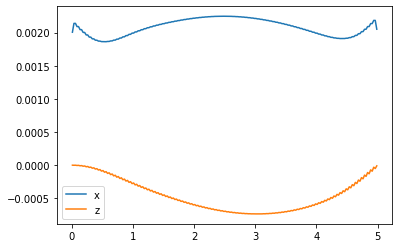

In [17]:
plt.figure()
plt.plot(dprop_dpram_times,total_derivs_x.real,label='x')
plt.plot(dprop_dpram_times,total_derivs_z.real,label='z')

plt.legend()
plt.show()


### Comparison with Finite difference

In [18]:
from tqdm.contrib import tenumerate

def compute_finite_difference_brute(
                        pt_instance: oqupy.SimpleProcessTensor,
                        hamiltonian,
                        initial_state,
                        target_state,
                        times,
                        operator,
                        h = 10**-6):
    ''' doesn't use the adjoint method, just computes the frichét derivatives by
    brute force'''

    assert operator.shape[0] == pt_instance.hilbert_space_dimension,\
         'input operator is a different H.S. dimension to the system'
    dt = pt_instance.dt
    def hamiltonian_perturbed(operator,h,dt,time):
        def _hamiltonian_perturbed(t):
            if time-dt/2 < t < time+dt/2:
                return hamiltonian(t) + h * operator
            return hamiltonian(t)
        return _hamiltonian_perturbed

    derivative_array = np.zeros(times.size,dtype=np.complex128)
    for i,time in tenumerate(times):
        ham_plus_h = hamiltonian_perturbed(operator,h,dt,time)
        ham_minus_h = hamiltonian_perturbed(operator,-h,dt,time)

        system_plus_h = oqupy.TimeDependentSystem(ham_plus_h)
        system_minus_h = oqupy.TimeDependentSystem(ham_minus_h)

        dynamics_forward = oqupy.compute_dynamics(
                    system_plus_h,
                    initial_state,
                    start_time=0,
                    process_tensor=pt_instance,
                    record_all=False,
                    progress_type='silent')
        dynamics_backward = oqupy.compute_dynamics(
                    system_minus_h,
                    initial_state,
                    start_time=0,
                    process_tensor=pt_instance,
                    record_all=False,
                    progress_type='silent')
        final_state_forward = dynamics_forward.states[0,:,:]
        final_state_backward = dynamics_backward.states[0,:,:]

        fidelity_forward = 1 - np.matmul(target_state,final_state_forward).trace()
        fidelity_backward = 1 - np.matmul(target_state,final_state_backward).trace()

        derivative = (fidelity_forward - fidelity_backward) / (2 * h)

        derivative_array[i] = derivative
        np.save('deriv_array',derivative_array)

    return derivative_array



In [19]:
generate_finite_differnce_z = False
generate_finite_differnce_x = False

In [20]:
if generate_finite_differnce_z:
    fd_z = compute_finite_difference_brute(
                process_tensor,
                hamiltonian_t,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=times,
                operator=oqupy.operators.sigma('z')
                )

    np.save('deriv_array_z',fd_z)


In [21]:
if generate_finite_differnce_x:
    fd_x = compute_finite_difference_brute(
                process_tensor,
                hamiltonian_t,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=times,
                operator=oqupy.operators.sigma('x')
                )
    np.save('deriv_array_x',fd_x)


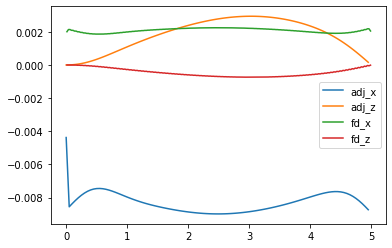

In [22]:

deriv_array_x = np.load('deriv_array_x.npy')
deriv_array_z = np.load('deriv_array_z.npy')
plt.plot(times,deriv_array_x.real,label='adj_x')
plt.plot(times,deriv_array_z.real,label='adj_z')

plt.plot(dprop_dpram_times,total_derivs_x.real,label='fd_x')
plt.plot(dprop_dpram_times,total_derivs_z.real,label='fd_z')

plt.legend()